In [1]:
library(tidyverse)
library(ggrepel)
library(plotly)
library(GGally)
library(edgeR)
library(aggregation)
library(splines)
library(statmod)
library(scales)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: limma


Attaching package: 'scales'


The followi

In [3]:
lethal_df <- read_csv("C:\\Users\\sterl\\Desktop\\Jayden Chronos test\\lethal_score.csv")

lethal_df %>% dim
lethal_df %>% head(3)

Rows: 17386 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Gene
dbl (1): lethal_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 17386     2

Gene,lethal_score
<chr>,<dbl>
RAN,0.9999566
RPS27A,0.9999523
RRM2,0.9999455


In [5]:
oldname <- c('DivCtl_A','Dropout_rep1_B','Dropout_rep2_C','Dropout_rep1_D','Dropout_rep2_E',
      'Dropout_rep1_F1','LD20_rep1_F2','LD90_rep1_F3','Dropout_rep2_G1','LD20_rep2_G2','LD90_rep2_G3',
      'Dropout_rep1_H1','LD20_rep1_H2','LD90_rep1_H3','Dropout_rep2_I1','LD20_rep2_I2','LD90_rep2_I3',
      'Dropout_rep1_J1','LD20_rep1_J2','LD90_rep1_J3','Dropout_rep2_K1','LD20_rep2_K2','LD90_rep2_K3',
      'Dropout_rep1_L1','LD20_rep1_L2','LD90_rep1_L3','Dropout_rep2_M1','LD20_rep2_M2','LD90_rep2_M3',
      'Dropout_rep1_N1','LD20_rep1_N2','LD90_rep1_N3','Dropout_rep2_O1','LD20_rep2_O2','LD90_rep2_O3',
      'sgRNA','Gene')

newname <- c('noT_day0_1','noT_day05_1','noT_day05_2','noT_day15_1','noT_day15_2',
      'noT_day20_1','LD20_day20_1','LD90_day20_1','noT_day20_2','LD20_day20_2','LD90_day20_2',
      'noT_day26_1','LD20_day26_1','LD90_day26_1','noT_day26_2','LD20_day26_2','LD90_day26_2',
      'noT_day31_1','LD20_day31_1','LD90_day31_1','noT_day31_2','LD20_day31_2','LD90_day31_2',
      'noT_day36_1','LD20_day36_1','LD90_day36_1','noT_day36_2','LD20_day36_2','LD90_day36_2',
      'noT_day41_1','LD20_day41_1','LD90_day41_1','noT_day41_2','LD20_day41_2','LD90_day41_2',
      'sgRNA','Gene')

oldnew_dict <- newname
names(oldnew_dict) <- oldname

In [7]:
count_df <- read_tsv("C:\\Users\\sterl\\Desktop\\Jayden Chronos test\\Lenka_TKOv3_screen.count.txt")
oldnames <- colnames(count_df)
colnames(count_df) <- oldnew_dict[oldnames]

Rows: 71090 Columns: 37
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): sgRNA, Gene
dbl (35): DivCtl_A, Dropout_rep1_B, Dropout_rep2_C, Dropout_rep1_D, Dropout_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
guide_efficiency <- read_csv("C:\\Users\\sterl\\Desktop\\Jayden Chronos test\\RKI1_full_guide_efficacy.csv")
colnames(guide_efficiency) <- c('sgRNA','guide_ef')

guide_efficiency %>% head

New names:
• `` -> `...1`
Rows: 71090 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (1): 0

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sgRNA,guide_ef
<chr>,<dbl>
EGFP:141-160_EGFP_-,0.28320663
EGFP:142-161_EGFP_-,0.20421797
EGFP:249-268_EGFP_+,0.16883987
EGFP:26-45_EGFP_-,0.18962388
EGFP:32-51_EGFP_+,0.05116299
EGFP:335-354_EGFP_+,0.44270607


In [11]:
genes <- count_df %>% select(c(sgRNA,Gene)) %>%
    group_by(Gene) %>% mutate(sgrna_id = Gene %>% paste(1:n(), sep='_')) %>%
    left_join(lethal_df) %>%
    left_join(guide_efficiency) %>%
    as.data.frame
rownames(genes) <- genes$sgrna_id

counts <- count_df %>% select(-c(sgRNA,Gene)) %>% as.data.frame
rownames(counts) <- genes$sgrna_id

dge <- DGEList(counts=counts, genes=genes)

lowCountGuides <- dge$counts %>% rowSums %>% .[.<10] %>% names
guides2keep <- dge$genes %>% rownames %>% setdiff(lowCountGuides)
dge <- dge[guides2keep,]

dge$samples <- dge$samples %>% 
    mutate(treatment = rownames(.) %>% gsub("_.*$","",.),
           replicate = rownames(.) %>% gsub("^.*_","",.),
           time = rownames(.) %>% gsub("^[^_]*_","",.) %>% gsub("_.*$","",.),
           timetreat = rownames(.) %>% gsub("_[^_]*$","",.))

dge$samples <- dge$samples %>% 
    mutate(timeN = time %>% gsub("day", "", .) %>% as.numeric,
           treatrep = paste(treatment, replicate, sep='_'),
           fullmodel = rownames(.))

dge <- calcNormFactors(dge)

dge %>% lapply(function(x){head(x,3)})

Joining with `by = join_by(Gene)`
Joining with `by = join_by(sgRNA)`


$counts
        noT_day0_1 noT_day05_1 noT_day05_2 noT_day15_1 noT_day15_2 noT_day20_1
CABP5_1        650         563        1080        1214         829         259
NRTN_1         744         676        1399        1959         620        1054
PPCS_1         731         503        1149         897         673         279
        LD20_day20_1 LD90_day20_1 noT_day20_2 LD20_day20_2 LD90_day20_2
CABP5_1          316           23         215          304           13
NRTN_1          1065          200         461          312           53
PPCS_1           308           40         164          135            0
        noT_day26_1 LD20_day26_1 LD90_day26_1 noT_day26_2 LD20_day26_2
CABP5_1         117           49           41         140          247
NRTN_1         1226         1036           82         190          103
PPCS_1          190          266           66          42           32
        LD90_day26_2 noT_day31_1 LD20_day31_1 LD90_day31_1 noT_day31_2
CABP5_1           21          83           89           22          76
NRTN_1            37         895         1139           99          92
PPCS_1            23         162          250           59          14
        LD20_day31_2 LD90_day31_2 noT_day36_1 LD20_day36_1 LD90_day36_1
CABP5_1          332           20         161           40           17
NRTN_1           132           21        1120          604           40
PPCS_1            38           15         215          143           74
        noT_day36_2 LD20_day36_2 LD90_day36_2 noT_day41_1 LD20_day41_1
CABP5_1         104          395            4         121            0
NRTN_1           86          226           30         694          351
PPCS_1            0           73            3         183           40
        LD90_day41_1 noT_day41_2 LD20_day41_2 LD90_day41_2
CABP5_1            0         198          205            0
NRTN_1            14           1           51            0
PPCS_1            25           0           51            0

$samples
            group lib.size norm.factors treatment replicate  time timetreat
noT_day0_1      1 40073036     1.201579       noT         1  day0  noT_day0
noT_day05_1     1 33720882     1.207173       noT         1 day05 noT_day05
noT_day05_2     1 60062198     1.184074       noT         2 day05 noT_day05
            timeN treatrep   fullmodel
noT_day0_1      0    noT_1  noT_day0_1
noT_day05_1     5    noT_1 noT_day05_1
noT_day05_2     5    noT_2 noT_day05_2

$genes
                                  sgRNA  Gene sgrna_id lethal_score   guide_ef
CABP5_1 chr19:48547138-48547157_CABP5_+ CABP5  CABP5_1   0.02338947 0.41042758
NRTN_1     chr19:5827797-5827816_NRTN_+  NRTN   NRTN_1   0.04146777 0.01360134
PPCS_1    chr1:42922341-42922360_PPCS_-  PPCS   PPCS_1   0.72354734 0.99896273

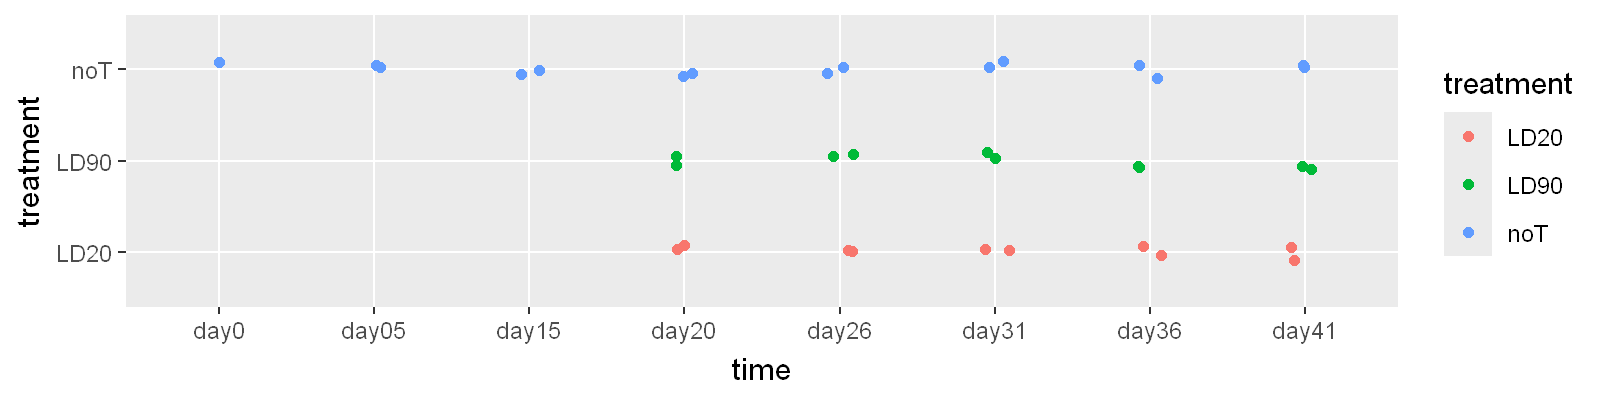

In [12]:
options(repr.plot.width = 8, repr.plot.height = 2, repr.plot.res = 200)

ggplot(dge$samples, aes(x=time, y=treatment, colour=treatment)) + geom_jitter(width=0.1, height=0.1)

In [14]:
logCPM <- cpm(dge, log=TRUE, prior.count=10)

logCPM_ts <- logCPM %>% as.data.frame %>%
    mutate(sgrna_id = rownames(.)) %>% 
    pivot_longer(-sgrna_id, names_to='fullmodel', values_to='logCPM') %>%
    left_join(dge$samples) %>%
    left_join(dge$genes) %>%
    rename(genesymbol = Gene)

logCPM %>% head(3)
logCPM_ts %>% head(3)


Joining with `by = join_by(fullmodel)`
Joining with `by = join_by(sgrna_id)`


,noT_day0_1,noT_day05_1,noT_day05_2,noT_day15_1,noT_day15_2,noT_day20_1,LD20_day20_1,LD90_day20_1,noT_day20_2,LD20_day20_2,⋯,LD90_day36_1,noT_day36_2,LD20_day36_2,LD90_day36_2,noT_day41_1,LD20_day41_1,LD90_day41_1,noT_day41_2,LD20_day41_2,LD90_day41_2
CABP5_1,3.817035,3.850560,3.980120,4.010982,3.988321,3.599361,3.885794,2.633787,3.464986,3.840819,⋯,2.588027,3.3558654,4.964003,1.883124,3.624539,-0.7489168,-0.7489168,3.8959500,4.748076,-0.7489168
NRTN_1,4.004182,4.104466,4.341027,4.680938,3.587337,5.569774,5.597219,5.626162,4.523323,3.876757,⋯,3.737968,3.0991349,4.178896,4.572747,6.085823,5.8122971,2.6352827,-0.5837437,2.834397,-0.7489168
PPCS_1,3.979702,3.695064,4.066197,3.593090,3.700040,3.701588,3.850308,3.372137,3.098322,2.742826,⋯,4.595624,-0.7489168,2.644611,1.543649,4.197599,2.7930435,3.4096688,-0.7489168,2.834397,-0.7489168


sgrna_id,fullmodel,logCPM,group,lib.size,norm.factors,treatment,replicate,time,timetreat,timeN,treatrep,sgRNA,genesymbol,lethal_score,guide_ef
<chr>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
CABP5_1,noT_day0_1,3.817035,1,40073036,1.201579,noT,1,day0,noT_day0,0,noT_1,chr19:48547138-48547157_CABP5_+,CABP5,0.02338947,0.4104276
CABP5_1,noT_day05_1,3.850560,1,33720882,1.207173,noT,1,day05,noT_day05,5,noT_1,chr19:48547138-48547157_CABP5_+,CABP5,0.02338947,0.4104276
CABP5_1,noT_day05_2,3.980120,1,60062198,1.184074,noT,2,day05,noT_day05,5,noT_2,chr19:48547138-48547157_CABP5_+,CABP5,0.02338947,0.4104276


Importance of components:
                            PC1      PC2      PC3      PC4      PC5      PC6
Standard deviation     135.2856 115.0822 76.01034 67.18603 63.19176 56.93229
Proportion of Variance   0.2584   0.1870  0.08157  0.06373  0.05637  0.04576
Cumulative Proportion    0.2584   0.4454  0.52692  0.59065  0.64703  0.69279
                            PC7      PC8      PC9     PC10     PC11     PC12
Standard deviation     52.77143 46.45503 45.34128 40.81606 39.75573 34.81208
Proportion of Variance  0.03932  0.03047  0.02902  0.02352  0.02231  0.01711
Cumulative Proportion   0.73210  0.76257  0.79159  0.81511  0.83742  0.85453
                           PC13    PC14     PC15    PC16     PC17     PC18
Standard deviation     33.40844 32.0430 30.54164 28.1678 27.55846 25.63788
Proportion of Variance  0.01576  0.0145  0.01317  0.0112  0.01072  0.00928
Cumulative Proportion   0.87029  0.8848  0.89796  0.9092  0.91988  0.92916
                           PC19     PC20     PC21     PC22

,PC1,PC2,PC3,PC4,PC5,PC6,group,lib.size,norm.factors,treatment,replicate,time,timetreat,timeN,treatrep,fullmodel
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
noT_day0_1,-25.99119,-160.5883,47.00295,-15.80644,3.339150,-3.984210,1,40073036,1.201579,noT,1,day0,noT_day0,0,noT_1,noT_day0_1
noT_day05_1,-25.29760,-159.6760,46.26339,-14.38352,3.373718,-4.784553,1,33720882,1.207173,noT,1,day05,noT_day05,5,noT_1,noT_day05_1
noT_day05_2,-26.63304,-157.3296,46.52442,-17.48608,3.810261,-2.638653,1,60062198,1.184074,noT,2,day05,noT_day05,5,noT_2,noT_day05_2


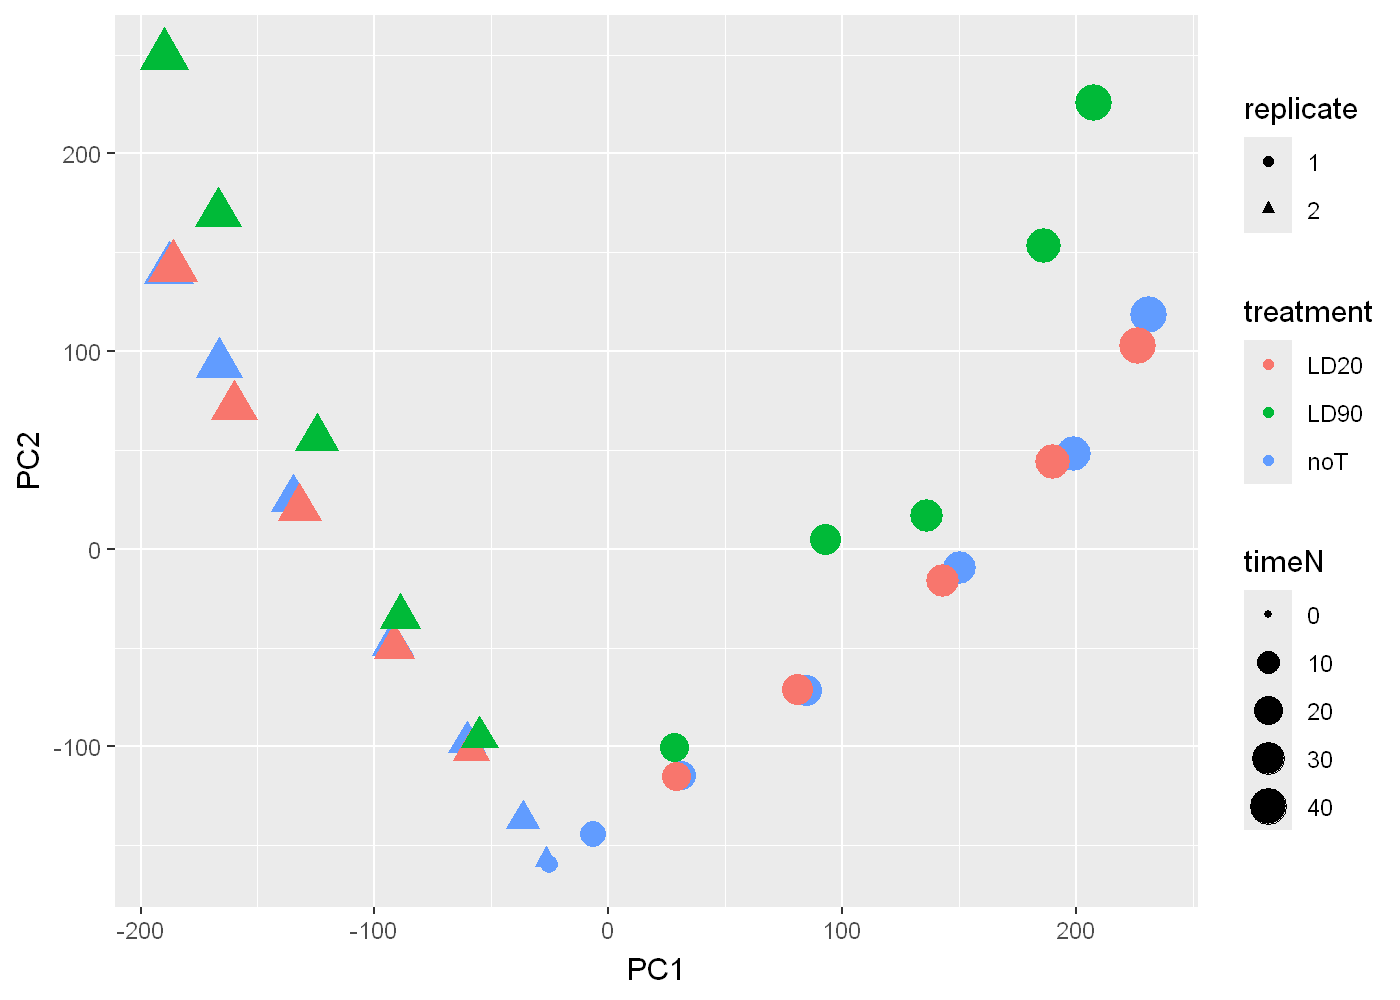

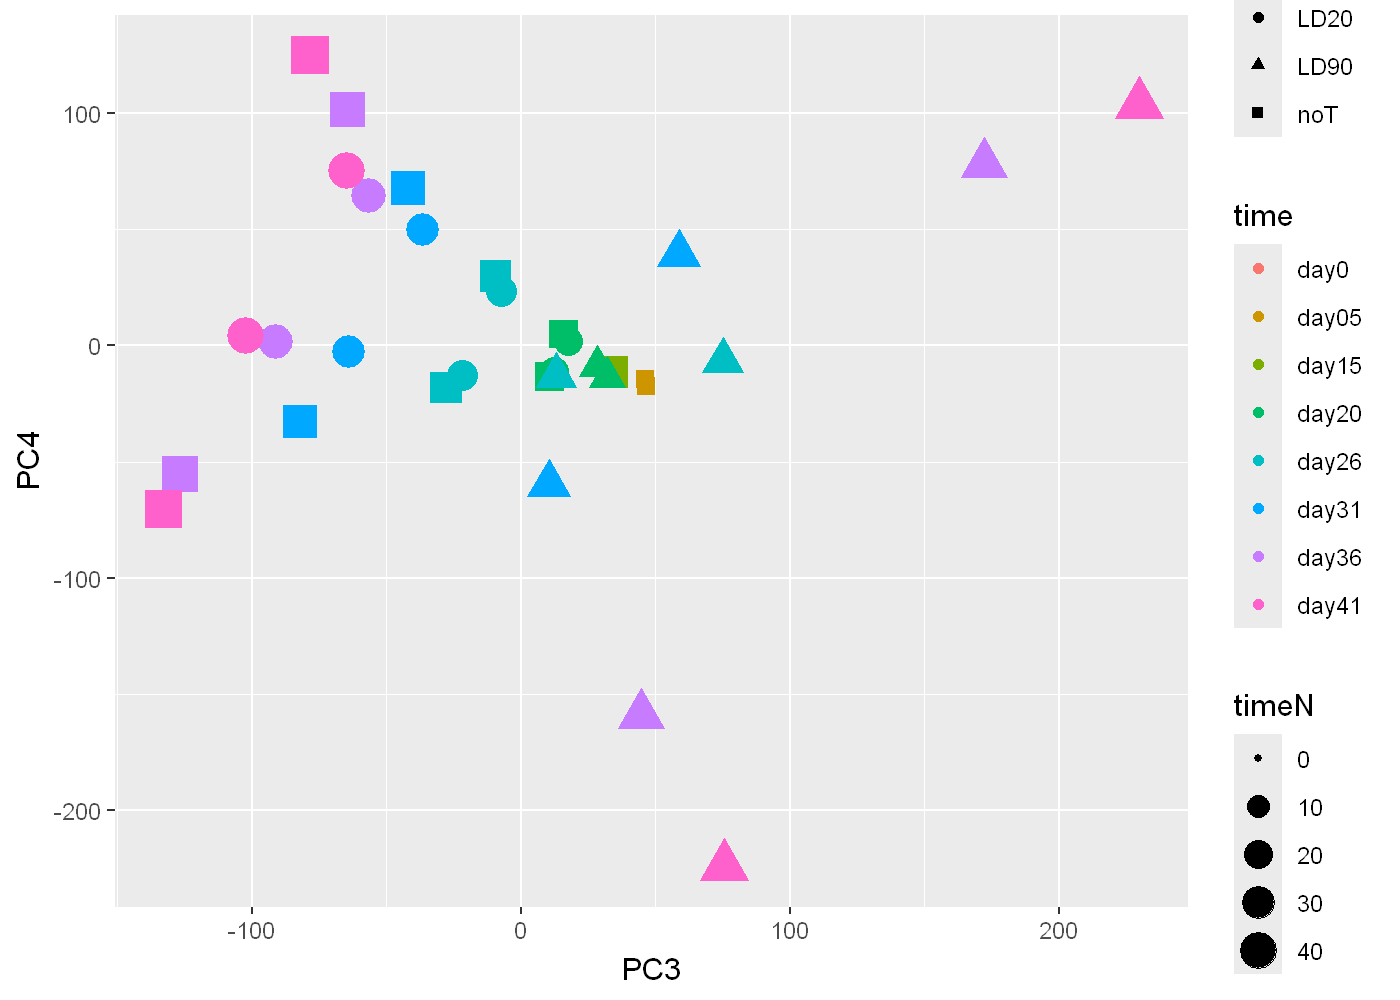

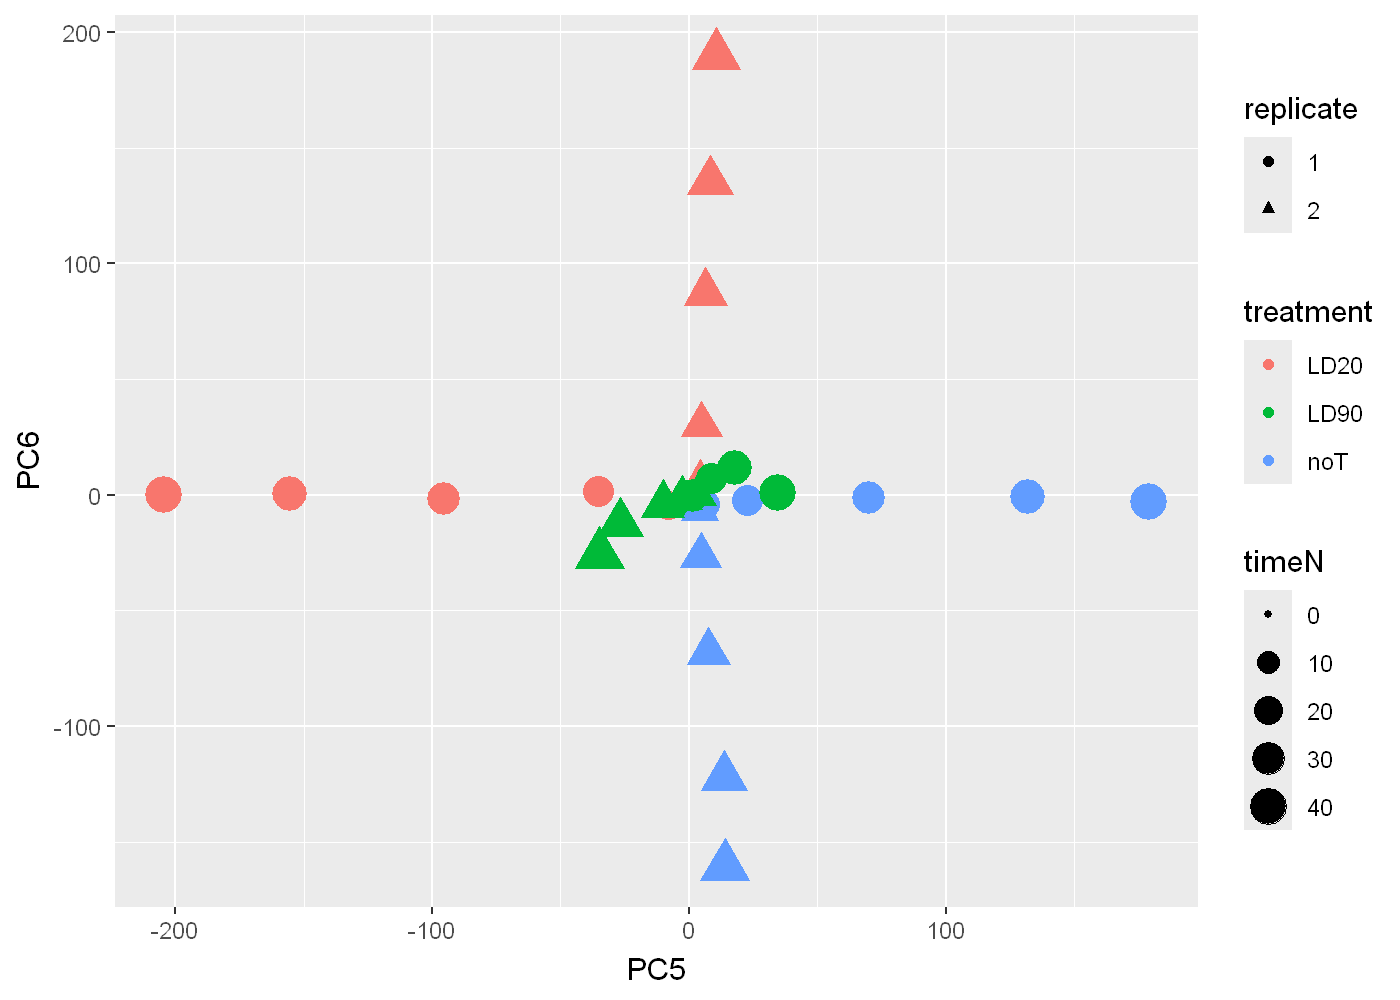

In [16]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 200)

pca_cpm <- logCPM %>% t %>% prcomp(center=TRUE, scale=TRUE)
summary(pca_cpm)

pca_df <- pca_cpm$x %>% as.data.frame %>% select(c(PC1,PC2,PC3,PC4,PC5,PC6)) %>% cbind(dge$samples[rownames(.),])

pca_df %>% head(3)

ggplot(pca_df, aes(x=PC1, y=PC2, colour=treatment, shape=replicate, size=timeN)) + geom_point()
ggplot(pca_df, aes(x=PC3, y=PC4, colour=time, shape=treatment, size=timeN)) + geom_point()
ggplot(pca_df, aes(x=PC5, y=PC6, colour=treatment, shape=replicate, size=timeN)) + geom_point()


In [18]:

time <- factor(dge$samples$timeN, levels=dge$samples$timeN %>% unique)
treatment <- factor(dge$samples$treatment, levels=dge$samples$treatment %>% unique)
replicate <- factor(dge$samples$replicate, levels=dge$samples$replicate%>% unique)
timetreat <- factor(dge$samples$timetreat, levels=dge$samples$timetreat %>% unique)
treatrep <- factor(dge$samples$treatrep, levels=dge$samples$treatrep %>% unique)
fullmodel <- factor(dge$samples$fullmodel, levels=dge$samples$fullmodel %>% unique)


design <- model.matrix(~timetreat)
colnames(design) <- colnames(design) %>% 
    gsub("fullmodel","",.) %>% 
    make.names
colnames(design)

[1] "X.Intercept."        "timetreatnoT_day05"  "timetreatnoT_day15" 
 [4] "timetreatnoT_day20"  "timetreatLD20_day20" "timetreatLD90_day20"
 [7] "timetreatnoT_day26"  "timetreatLD20_day26" "timetreatLD90_day26"
[10] "timetreatnoT_day31"  "timetreatLD20_day31" "timetreatLD90_day31"
[13] "timetreatnoT_day36"  "timetreatLD20_day36" "timetreatLD90_day36"
[16] "timetreatnoT_day41"  "timetreatLD20_day41" "timetreatLD90_day41"

In [20]:

fit <- lmFit(logCPM, design)
fit2 <- eBayes(fit)

results <- topTable(fit2, adjust="BH", number = Inf)

results <- results %>% cbind(dge$genes[rownames(results),])

results %>% head

,X.Intercept.,timetreatnoT_day05,timetreatnoT_day15,timetreatnoT_day20,timetreatLD20_day20,timetreatLD90_day20,timetreatnoT_day26,timetreatLD20_day26,timetreatLD90_day26,timetreatnoT_day31,⋯,timetreatLD90_day41,AveExpr,F,P.Value,adj.P.Val,sgRNA,Gene,sgrna_id,lethal_score,guide_ef
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
ZNF668_2,3.475659,0.14652074,1.3776879,2.7822087,2.6810878,2.0689049,4.460851,4.451238,3.382479,6.267922,⋯,3.940770,7.347389,281.8183,2.187595e-21,1.549539e-16,chr16:31075529-31075548_ZNF668_+,ZNF668,ZNF668_2,0.07504867,0.9985187
NAB2_2,4.678056,0.13261299,-0.2460247,0.5825282,0.4102079,0.3893601,1.807183,1.908740,1.405415,3.093324,⋯,3.676214,6.889663,228.5205,2.031464e-20,4.692304e-16,chr12:57487173-57487192_NAB2_+,NAB2,NAB2_2,0.06427655,0.9985124
DENND4B_4,4.113808,-0.01553562,0.2616040,1.0648734,0.8908755,0.2768462,2.423434,2.087405,2.094935,3.601314,⋯,4.008679,6.735304,226.9280,2.188099e-20,4.692304e-16,chr1:153915480-153915499_DENND4B_-,DENND4B,DENND4B_4,0.07323419,0.9972548
PAPPA2_1,4.762166,0.12616277,0.1507239,0.7717201,0.7106629,0.6416838,1.178869,1.287391,1.157885,1.620039,⋯,2.018490,6.105627,222.8738,2.649784e-20,4.692304e-16,chr1:176640224-176640243_PAPPA2_-,PAPPA2,PAPPA2_1,0.03135620,0.9969408
FAM161B_4,4.813148,0.02527193,0.3689667,0.7205135,0.7050314,0.5449735,1.479596,1.487050,1.400885,2.403951,⋯,2.127950,6.475119,202.4009,7.368553e-20,8.932679e-16,chr14:74413203-74413222_FAM161B_-,FAM161B,FAM161B_4,0.05330226,0.9998254
MOB2_1,5.079083,-0.10927141,0.2645492,0.8121129,0.8317754,0.4315780,1.569737,1.566458,1.308222,2.577159,⋯,2.970678,6.817051,201.8957,7.566540e-20,8.932679e-16,chr11:1491503-1491522_MOB2_-,MOB2,MOB2_1,0.04185128,0.9970090


In [22]:
fit <- lmFit(logCPM, design)

contrast <- "timetreatLD90_day20 - timetreatnoT_day20"
cont.wt <- makeContrasts(contrast, levels=design)

fit2 <- contrasts.fit(fit, cont.wt)
fit2 <- eBayes(fit2)

results <- topTable(fit2, adjust="BH", number = Inf)

results <- results %>% cbind(dge$genes[rownames(results),])
results %>% head(3)
write.table(results, file ="LD90 - UT Day 20 Limma sgRNA.txt", sep =",", quote = FALSE, row.names = F)

results_by_gene <- results %>% transmute(Gene, pval=P.Value, guideEf=guide_ef, logFC, lethal_score) %>%
    group_by(Gene) %>% summarise(lancasterPval = pval %>% lancaster(guideEf),
                                 fisherPval = pval %>% fisher,
                                 meanLogFC = weighted.mean(logFC, guideEf),
                                 lethal_score = mean(lethal_score)) %>% ungroup %>%
    arrange(lancasterPval)

results_by_gene %>% head

,logFC,AveExpr,t,P.Value,adj.P.Val,B,sgRNA,Gene,sgrna_id,lethal_score,guide_ef
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
DYX1C1_4,-4.220138,2.3048894,-4.265123,0.0003317048,1,-4.560660,chr15:55731761-55731780_DYX1C1_-,DYX1C1,DYX1C1_4,NA,0.9954732
GEMIN5_4,2.339571,-0.0526834,4.225148,0.0003653123,1,-4.561049,chr5:154317518-154317537_GEMIN5_+,GEMIN5,GEMIN5_4,0.9805670,0.9956016
WDR55_1,2.746928,0.6713040,4.187692,0.0003998845,1,-4.561416,chr5:140048924-140048943_WDR55_+,WDR55,WDR55_1,0.9220571,0.9988311


Gene,lancasterPval,fisherPval,meanLogFC,lethal_score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
FURIN,0.0009616027,0.002139506,-1.9242475,0.2306297
DYX1C1,0.0014888865,0.010550506,-2.3089116,NA
WDR74,0.0018241738,0.013456484,-1.9296450,0.9946166
SMC2,0.0019252771,0.019076751,0.4030698,0.9788387
AARS,0.0024563461,0.012411902,-1.6433589,NA
GEMIN5,0.0049224325,0.019997988,0.9843166,0.9805670


In [23]:
ctrl_df <- count_df %>% group_by(Gene) %>% 
    summarise(ctrl_sum = sum(noT_day0_1), 
              ctrl_min = min(noT_day0_1), 
              ctrl_max = max(noT_day0_1), 
              ctrl_n = length(noT_day0_1), 
              ctrl_agg = paste0(noT_day0_1, collapse='|')) %>% 
    ungroup %>% 
    rename(genesymbol = Gene)

In [24]:
dge_tc <- dge

dge_tc$samples %>% head

,group,lib.size,norm.factors,treatment,replicate,time,timetreat,timeN,treatrep,fullmodel
,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
noT_day0_1,1,40073036,1.201579,noT,1,day0,noT_day0,0,noT_1,noT_day0_1
noT_day05_1,1,33720882,1.207173,noT,1,day05,noT_day05,5,noT_1,noT_day05_1
noT_day05_2,1,60062198,1.184074,noT,2,day05,noT_day05,5,noT_2,noT_day05_2
noT_day15_1,1,64966766,1.203465,noT,1,day15,noT_day15,15,noT_1,noT_day15_1
noT_day15_2,1,44675360,1.214724,noT,2,day15,noT_day15,15,noT_2,noT_day15_2
noT_day20_1,1,19563556,1.148679,noT,1,day20,noT_day20,20,noT_1,noT_day20_1


In [25]:
X <- ns(dge_tc$samples$timeN, df=1)

In [26]:
treat <- factor(dge_tc$samples$treatment, ,levels=c('noT','LD20','LD90'))
rep <- factor(dge_tc$samples$replicate)
design <- model.matrix(~rep + treat*X)
fit <- lmFit(cpm(dge_tc, log=TRUE, prior.count=10), design)
fit <- eBayes(fit)

In [27]:
contrast = 'X'

results <- topTable(fit, adjust="BH", number = Inf, coef=contrast)

results <- results %>% cbind(dge$genes[rownames(results),])
results %>% head(3)

results_by_gene <- results %>% transmute(Gene, pval=P.Value, guideEf=guide_ef, logFC, lethal_score) %>%
    group_by(Gene) %>% summarise(lancasterPval = pval %>% lancaster(guideEf),
                                 fisherPval = pval %>% fisher,
                                 meanLogFC = weighted.mean(logFC, guideEf),
                                 lethal_score = mean(lethal_score)) %>% ungroup %>%
    arrange(lancasterPval)

results_by_gene %>% head



,logFC,AveExpr,t,P.Value,adj.P.Val,B,sgRNA,Gene,sgrna_id,lethal_score,guide_ef
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
ZNF771_2,10.318513,6.084110,14.14306,2.048432e-16,7.342395e-12,24.18885,chr16:30429589-30429608_ZNF771_-,ZNF771,ZNF771_2,0.08310108,0.9972955
CDKN2A_4,8.759755,6.916415,14.13761,2.073157e-16,7.342395e-12,24.17989,chr9:21974692-21974711_CDKN2A_-,CDKN2A,CDKN2A_4,0.02293337,0.9991706
ZNF668_2,9.929488,7.347389,13.64571,6.199822e-16,1.463840e-11,23.35497,chr16:31075529-31075548_ZNF668_+,ZNF668,ZNF668_2,0.07504867,0.9985187


Gene,lancasterPval,fisherPval,meanLogFC,lethal_score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
LacZ,8.398637e-43,5.731869e-54,2.450731,NA
CDKN2A,9.152199e-28,5.854786e-27,7.727891,0.02293337
CHORDC1,9.326922e-28,3.270738e-28,-6.533737,0.82078564
RPP21,1.133570e-26,3.768620e-27,-6.638976,0.92321509
AURKB,6.618338e-24,2.309772e-24,-5.790119,0.99458797
CDC6,2.102675e-23,2.780011e-23,-5.349171,0.98917405


In [28]:
dge_tc <- dge

dge_tc$samples %>% head
X <- ns(dge_tc$samples$timeN, df=1)

treat <- factor(dge_tc$samples$treatment, ,levels=c('noT','LD20','LD90'))
rep <- factor(dge_tc$samples$replicate)
design <- model.matrix(~rep + treat*X)
fit <- lmFit(cpm(dge_tc, log=TRUE, prior.count=10), design)
fit <- eBayes(fit)

contrast = 'X'

results <- topTable(fit, adjust="BH", number = Inf, coef=contrast)

results <- results %>% cbind(dge$genes[rownames(results),])
results %>% head(3)

results_by_gene <- results %>% transmute(Gene, adj_pval=adj.P.Val, guideEf=guide_ef, logFC, lethal_score) %>%
    group_by(Gene) %>% summarise(lancasterPval = adj_pval %>% lancaster(guideEf),
                                 fisherPval = adj_pval %>% fisher,
                                 meanLogFC = weighted.mean(logFC, guideEf),
                                 lethal_score = mean(lethal_score)) %>% ungroup %>%
    arrange(lancasterPval)

results_by_gene %>% head(10)

,group,lib.size,norm.factors,treatment,replicate,time,timetreat,timeN,treatrep,fullmodel
,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
noT_day0_1,1,40073036,1.201579,noT,1,day0,noT_day0,0,noT_1,noT_day0_1
noT_day05_1,1,33720882,1.207173,noT,1,day05,noT_day05,5,noT_1,noT_day05_1
noT_day05_2,1,60062198,1.184074,noT,2,day05,noT_day05,5,noT_2,noT_day05_2
noT_day15_1,1,64966766,1.203465,noT,1,day15,noT_day15,15,noT_1,noT_day15_1
noT_day15_2,1,44675360,1.214724,noT,2,day15,noT_day15,15,noT_2,noT_day15_2
noT_day20_1,1,19563556,1.148679,noT,1,day20,noT_day20,20,noT_1,noT_day20_1


,logFC,AveExpr,t,P.Value,adj.P.Val,B,sgRNA,Gene,sgrna_id,lethal_score,guide_ef
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
ZNF771_2,10.318513,6.084110,14.14306,2.048432e-16,7.342395e-12,24.18885,chr16:30429589-30429608_ZNF771_-,ZNF771,ZNF771_2,0.08310108,0.9972955
CDKN2A_4,8.759755,6.916415,14.13761,2.073157e-16,7.342395e-12,24.17989,chr9:21974692-21974711_CDKN2A_-,CDKN2A,CDKN2A_4,0.02293337,0.9991706
ZNF668_2,9.929488,7.347389,13.64571,6.199822e-16,1.463840e-11,23.35497,chr16:31075529-31075548_ZNF668_+,ZNF668,ZNF668_2,0.07504867,0.9985187


Gene,lancasterPval,fisherPval,meanLogFC,lethal_score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
LacZ,2.421265e-24,1.481147e-27,2.450731,NA
CDKN2A,3.891298e-19,3.102632e-18,7.727891,0.02293337
CHORDC1,5.503484e-19,2.042500e-19,-6.533737,0.82078564
RPP21,2.320809e-18,8.236345e-19,-6.638976,0.92321509
AURKB,2.035359e-16,7.529068e-17,-5.790119,0.99458797
PSMA3,4.014270e-16,1.488059e-16,-5.735575,0.99936317
POLD3,5.078155e-16,2.406431e-16,-5.534055,0.99005963
MARS2,5.241361e-16,2.105284e-16,-5.885865,0.74477328
CDC6,6.145909e-16,8.820080e-16,-5.349171,0.98917405


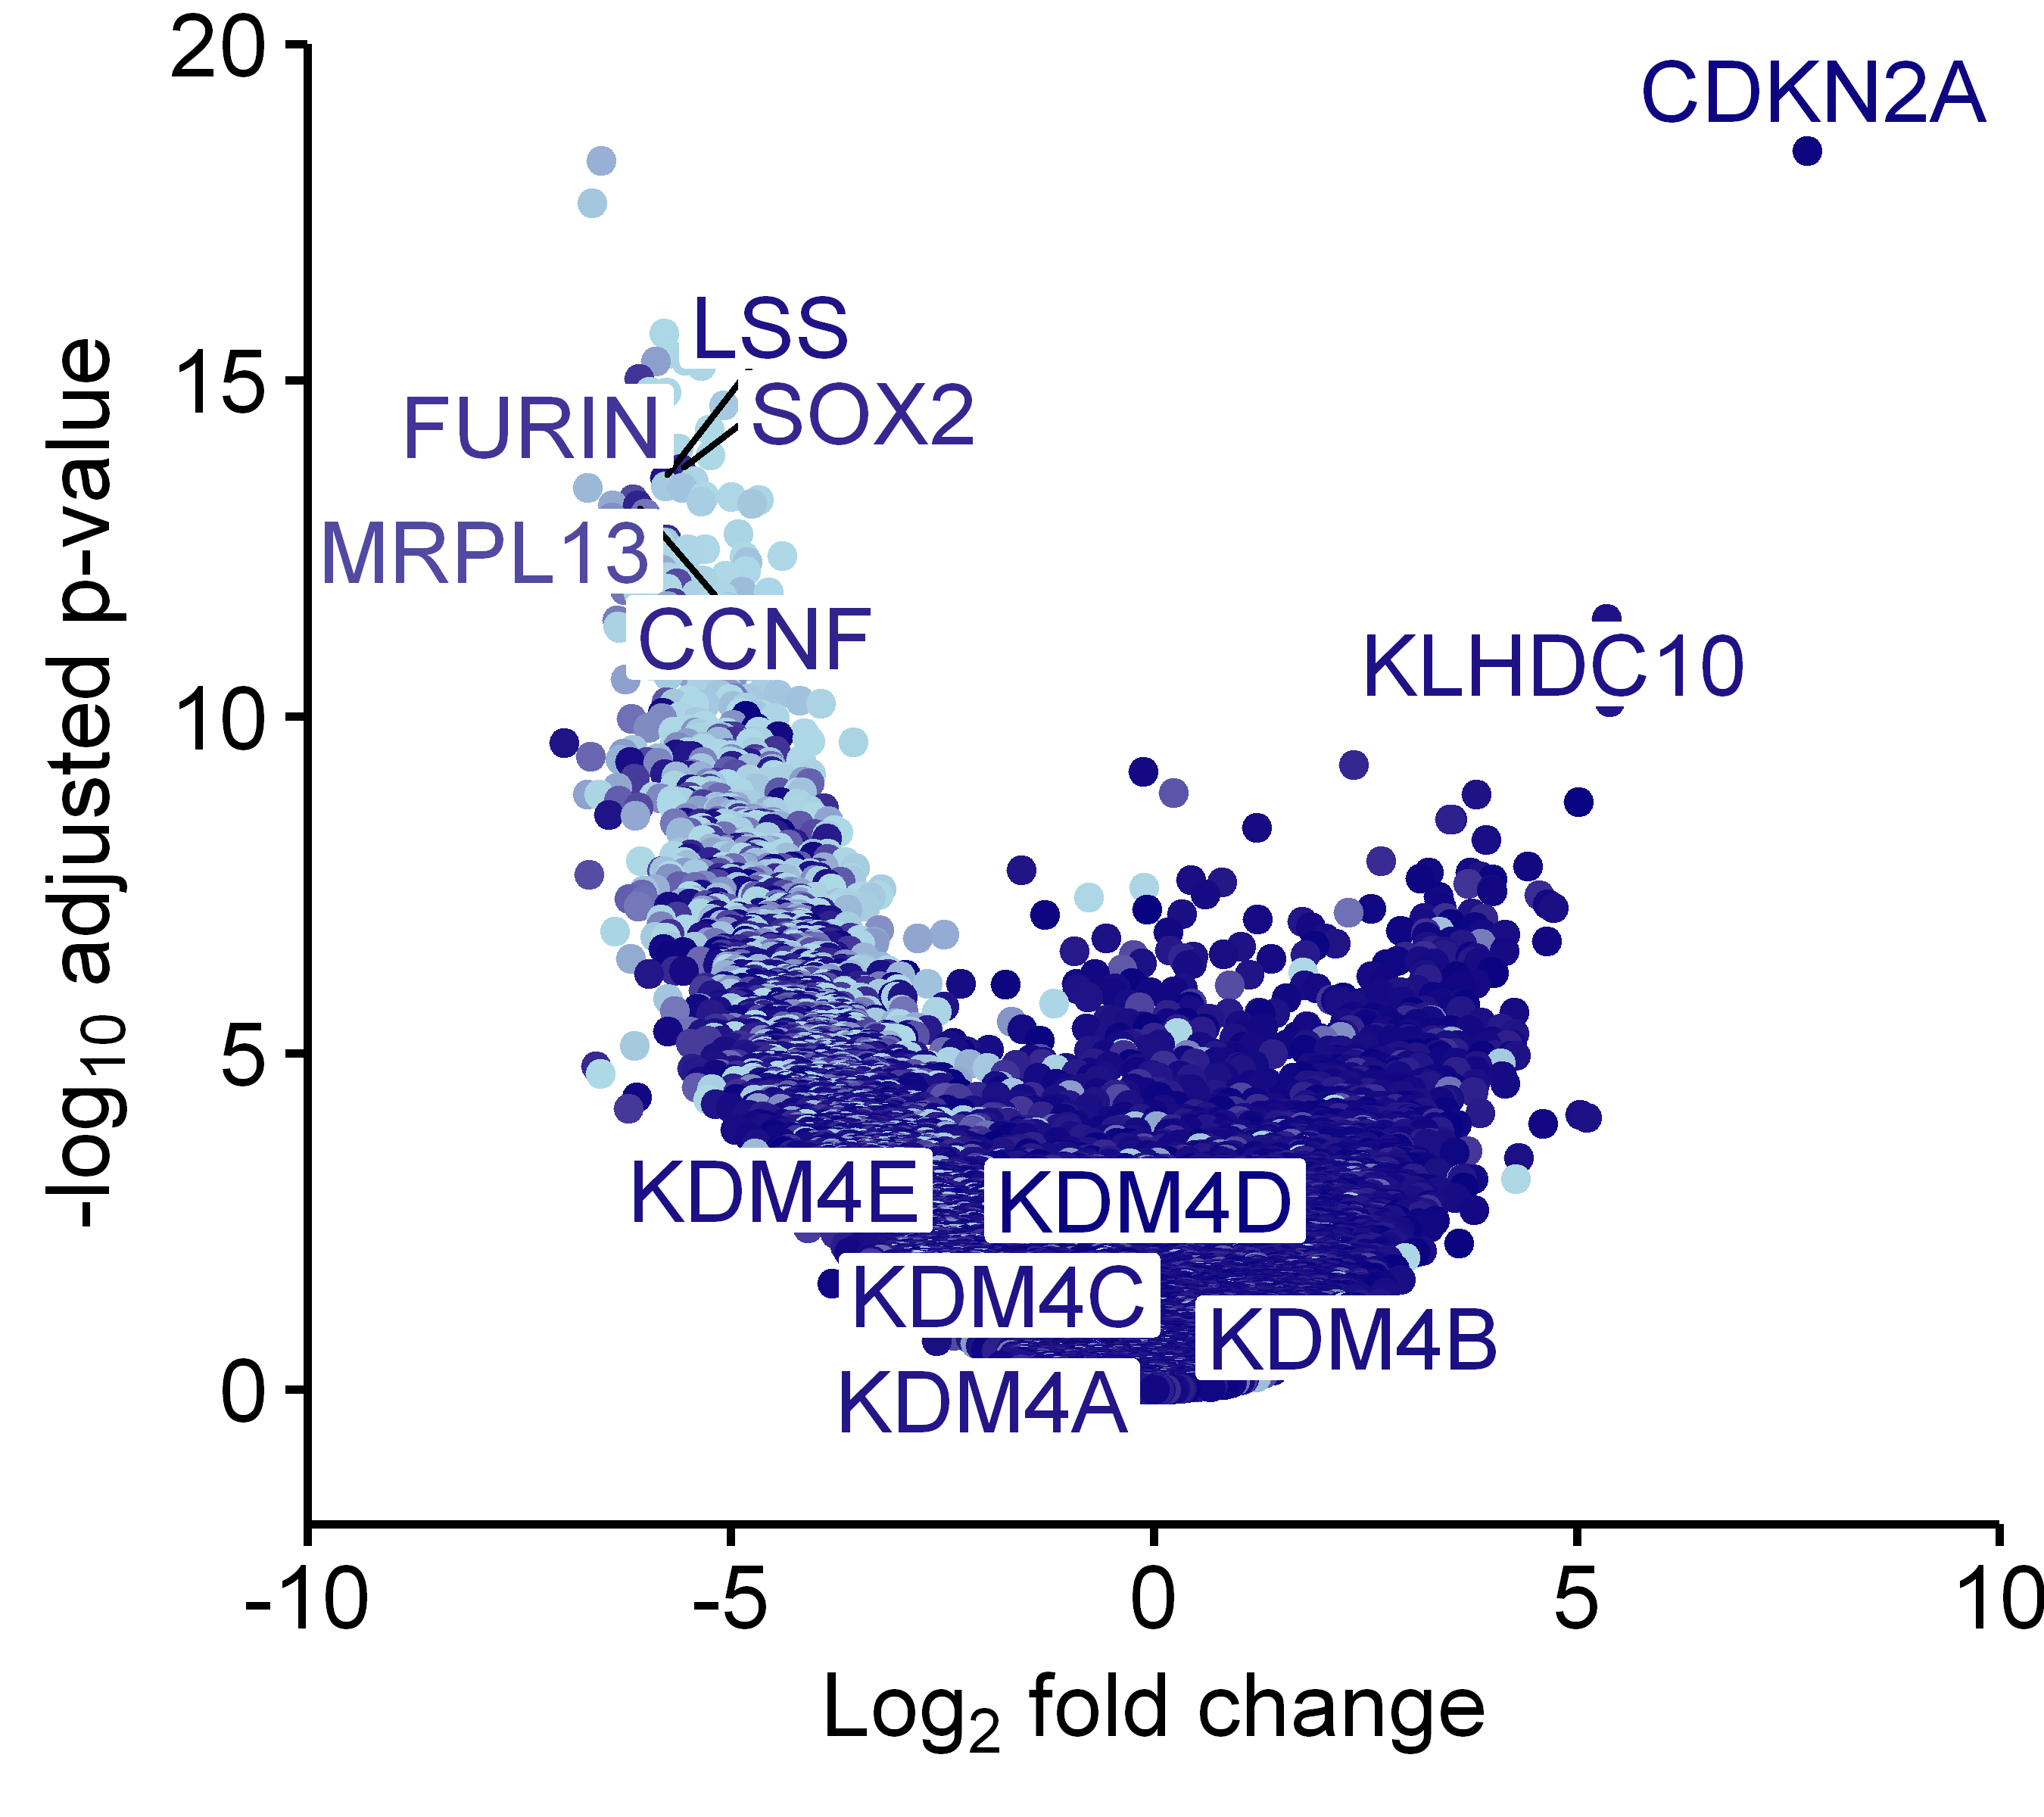

In [30]:
options(repr.plot.width = 9, repr.plot.height = 8, repr.plot.res = 300)
genes_of_interest <- c("KDM4A", "KDM4B", "KDM4C", "KDM4D", "KDM4E")
results_by_gene <- results_by_gene %>% filter(!is.na(lethal_score))

results_by_gene <- results_by_gene %>% 
    filter(meanLogFC >= -10 & meanLogFC <= 10, -log10(lancasterPval) >= -2 & -log10(lancasterPval) <= 20)

p <- ggplot(results_by_gene, aes(x=meanLogFC, y=-log10(lancasterPval), colour=lethal_score)) + geom_point(size = 4) + 
    geom_label_repel(data = results_by_gene %>% filter((meanLogFC > 4 & -log10(lancasterPval) > 11) &  lethal_score <0.4 | 
                                                        (meanLogFC < -4 & -log10(lancasterPval) > 13) &  lethal_score <0.4 |
                                                         Gene %in% genes_of_interest), 
                    aes(label=Gene), 
        max.overlaps = 100,
        max.iter = 50000,
        segment.color = "black",
        force = 50,
        segment.size = 1, 
        box.padding = unit(0, "lines"),
        size = 9.5,
        label.size = NA) +

    theme_classic(base_size = 28) +  
    theme(
      plot.background = element_blank(),
      panel.background = element_rect(fill = "white"),
      axis.text = element_text(size = 28, family = "", colour = "black"),
      axis.title = element_text(size = 28, family = ""),
      legend.position = "none",
        axis.ticks = element_line(colour = "black")) +
        labs(x = expression(paste("Log"[2], " fold change")), y = expression(paste("-log"[10], " adjusted p-value"))) +
        scale_colour_gradient(limits = c(0, 1), low = '#00007F', high = '#ADD8E6', guide = guide_colourbar(barheight = unit(3, "in"), 
                                                                    frame.colour = "black", 
                                                                    ticks.colour = "black", 
                                                                    frame.linewidth = 1, 
                                                                    ticks.linewidth = 1))+
    scale_x_continuous(expand = c(0,0), limits = c(-10,10), breaks = seq(-10,10, by = 5),sec.axis = sec_axis(~ ., breaks = NULL)) +
    scale_y_continuous(expand = c(0,0), limits = c(-2,20), breaks = seq(0,30, by = 5),sec.axis = sec_axis(~ ., breaks = NULL))

plot(p)


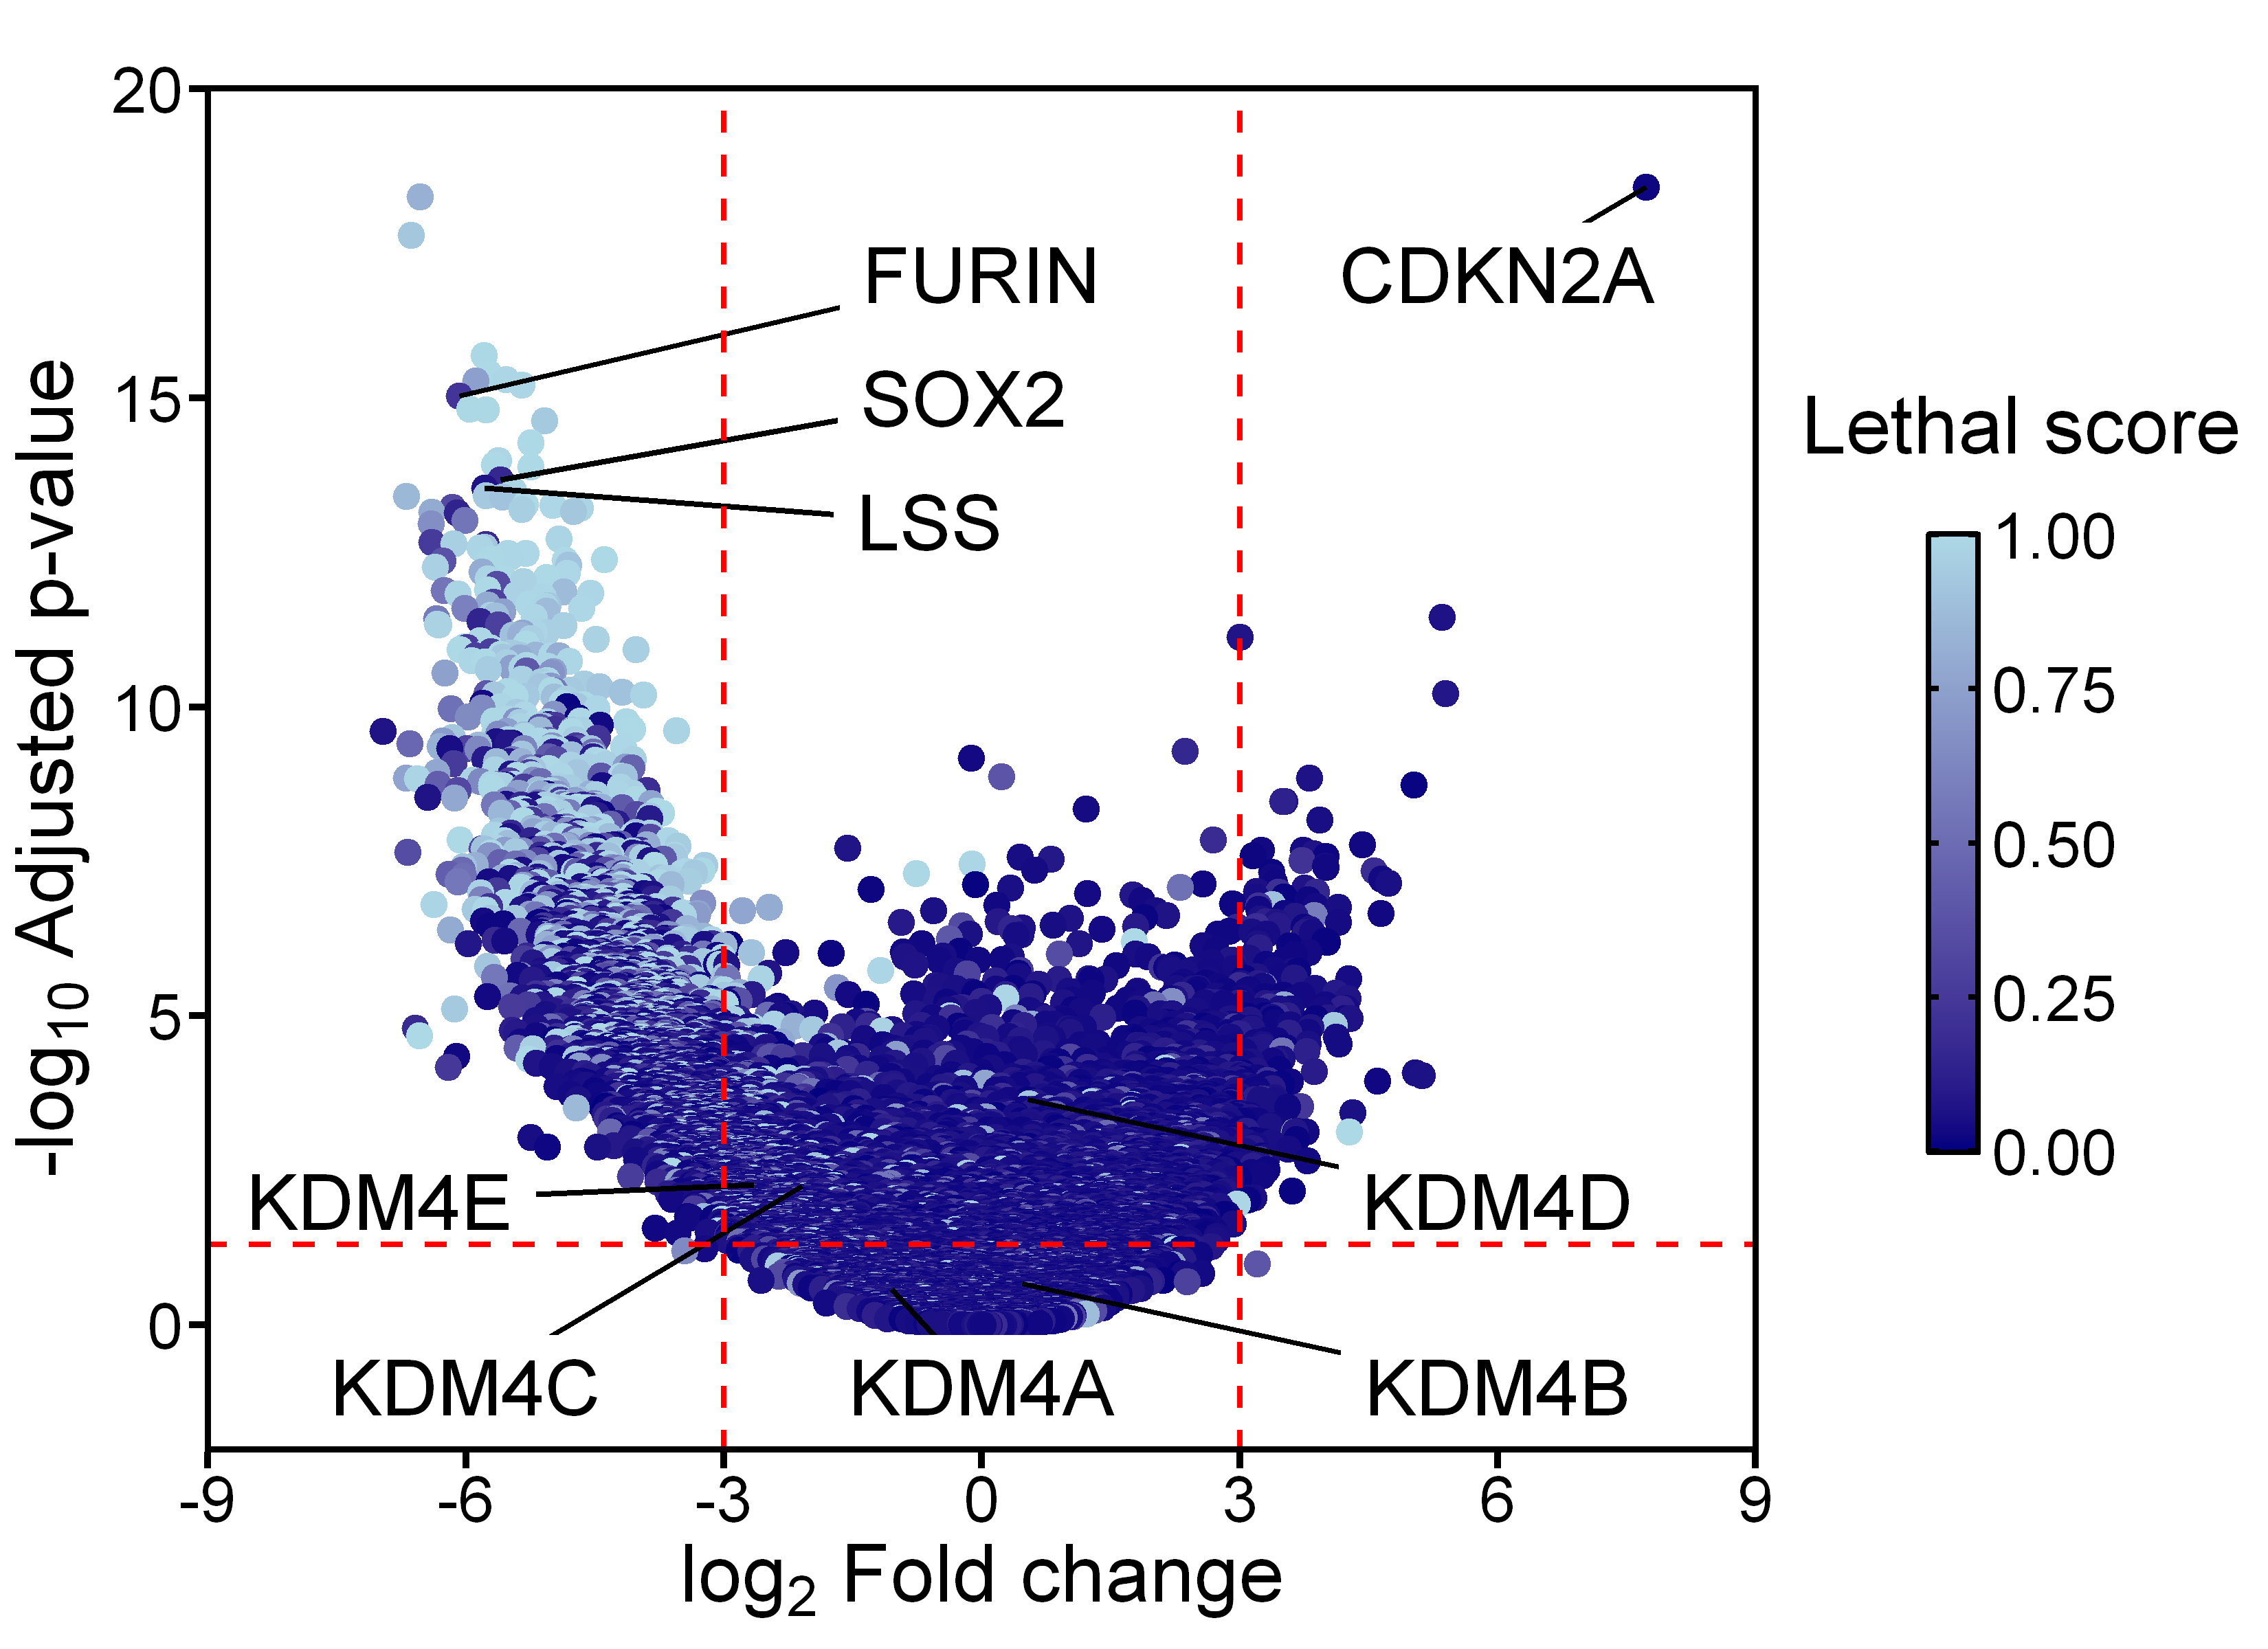

In [227]:
library(ggplot2)
library(dplyr)
library(tibble)

options(repr.plot.width = 11, repr.plot.height = 8, repr.plot.res = 300)

labels_df <- tibble::tibble(
  Gene = c("FURIN", "SOX2", "LSS", "CDKN2A", "KDM4A", "KDM4B", "KDM4C", "KDM4D", "KDM4E"),
  x = c(0, -0.2, -0.6, 6, 0, 6, -6, 6, -7),
  y = c(17, 15, 13, 17, -1, -1, -1, 2, 2)
)

results_by_gene <- results_by_gene %>%
  filter(!is.na(lethal_score)) %>%
  filter(meanLogFC >= -10 & meanLogFC <= 10,
         -log10(lancasterPval) >= -2 & -log10(lancasterPval) <= 20)

labels_data <- results_by_gene %>%
  filter(Gene %in% labels_df$Gene) %>%
  inner_join(labels_df, by = "Gene")

p <- ggplot(results_by_gene, aes(x = meanLogFC, y = -log10(lancasterPval), colour = lethal_score)) +
  geom_point(size = 4) +
  
  geom_segment(
    data = labels_data,
    aes(x = meanLogFC, y = -log10(lancasterPval), xend = x, yend = y),
    inherit.aes = FALSE,
    color = "black",
    linewidth = 1
  ) +
  
  geom_label(
    data = labels_data,
    aes(x = x, y = y, label = Gene),
    inherit.aes = FALSE,
    size = 9.5,
    label.size = NA
  ) +
  
  theme(
    text               = element_text(size = 28),   
    plot.background    = element_blank(),
    panel.background   = element_rect(fill = "white"),
    panel.border       = element_rect(color = "black", fill = NA, linewidth = 2),  
    axis.line          = element_blank(),  
    axis.ticks         = element_line(color = "black", linewidth = 1.2), 
    axis.ticks.length  = unit(0.2, "cm"),
    axis.text          = element_text(color = "black"),   
    axis.title         = element_text(color = "black"),  
    legend.position    = "right",
    
    plot.margin        = margin(t = 30, r = 5, b = 5, l = 5)
  ) +
  
  labs(
    x = expression(paste("log"[2], " Fold change")),
    y = expression(paste("-log"[10], " Adjusted p-value"))
  ) +
  
scale_colour_gradient(
  name  = "Lethal score",
  limits = c(0, 1),
  low   = '#00007F',
  high  = '#ADD8E6',
  guide = guide_colourbar(
    barheight       = unit(3, "in"),
    frame.colour    = "black",
    ticks.colour    = "black",
    frame.linewidth = 1,
    ticks.linewidth = 1,
    
    title.position  = "top",
    title.hjust     = 0.5,
    label.hjust     = 0.5,
    
    title.theme = element_text(
      margin = margin(b = 25) 
    )
  )
) +
theme(
  legend.title = element_text(hjust = 0.5),
  legend.text  = element_text(hjust = 0.5)
) +
theme(
  legend.title = element_text(hjust = 0.5),
  legend.text  = element_text(hjust = 0.5)
) +
  
  scale_x_continuous(
    limits = c(-9, 9),
    breaks = seq(-9, 9, by = 3),
    expand = c(0.0017, 0),    # tiny expansion
    sec.axis = sec_axis(~ ., breaks = NULL)
  ) +
  scale_y_continuous(
    limits = c(-2, 20),
    breaks = seq(0, 30, by = 5),
    expand = c(0.0025, 0),    # tiny expansion
    sec.axis = sec_axis(~ ., breaks = NULL)
  ) +
  
  geom_vline(xintercept = c(-3, 3), linetype = "dashed", color = "red", linewidth = 1) +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red", linewidth = 1)

plot(p)

ggsave(filename = "C:\\Users\\sterl\\Desktop\\Jayden Chronos test\\limma_graph.jpeg", plot = p, dpi = 72, width = 11, height = 8)
